<center><h1> Projet Final : Pédiction du tempo de musiques Spotify avec des forêts aléatoires <h1><center>

**Meta-information** :

**Title**: Spotify Dataset 1921-2020, 160k+ Tracks

**Subtitle**: Audio features of 160k+ tracks, popularity metrics of 1M+ artists

**Source**: Spotify Web API

**Creator**: Yamac Eren Ay

**Release Date** (of Last Version): April 2021

**Information sur les variables** :

- **valence** : Indicateur émotionnel du morceau, allant de 0 à 1. Plus la valeur est élevée, plus la musique est perçue comme positive ou joyeuse.

- **year** : L'année de sortie du morceau.

- **acousticness** : Mesure de l’acoustique du morceau, allant de 0 à 1. Une valeur élevée signifie que la musique est principalement acoustique.

- **artists** : La liste des artistes interprètes du morceau. Cela peut être un ou plusieurs artistes.

- **danceability** : Indicateur de la capacité du morceau à être dansé, allant de 0 à 1. Plus la valeur est élevée, plus la musique est adaptée à la danse.

- **duration_ms** : La durée du morceau en millisecondes.

- **energy** : Mesure de l'intensité et de l'activité de la musique, allant de 0 à 1. Une valeur élevée signifie que la musique est énergique.

- **explicit** : Indique si le morceau contient des paroles explicites. 0 pour non explicite et 1 pour explicite.

- **id** : Identifiant unique du morceau dans la base de données de Spotify.

- **instrumentalness** : Mesure la probabilité qu’un morceau soit instrumental, c’est-à-dire sans voix chantées. Si la valeur d’Instrumentalness est proche de 0, cela indique que le morceau contient des voix chantées ou des éléments vocaux (comme des chœurs, des paroles, ou des sons parlés)

- **key** : La tonalité musicale du morceau. Les valeurs vont de 0 (Do) à 11 (Si).

- **liveness** : Indicateur de la présence d'un public ou d’une performance en direct dans l'enregistrement, allant de 0 à 1.

- **loudness** : Moyenne de l’amplitude du signal sur toute la durée du morceau, en tenant compte de la perception humaine du volume sonore.

- **mode** : Indique si la musique est dans une tonalité majeure (1) ou mineure (0).

- **name** : Le titre du morceau.

- **popularity** : La popularité du morceau sur Spotify, sur une échelle de 0 à 100. Plus la valeur est élevée, plus le morceau est populaire.

- **release_date** : La date de sortie du morceau.

- **speechiness** : Mesure la présence de mots parlés dans un morceau.

- **tempo** : Le tempo de la musique, exprimé en battements par minute (BPM).

## Importation de la base et des libs:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import lime
import lime.lime_tabular
import shap
# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from lime.lime_tabular import LimeTabularExplainer

from imblearn.under_sampling import RandomUnderSampler

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('data_spotify.csv')
data.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
89817,0.3840,2008,0.206,['Mother Mother'],0.6120,195973,0.581,0,3Pu0pOciPNbaTdfVY5538p,0.0037,5,0.124,-6.041,1,Miles,51,2008-09-23,0.0365,178.146
39200,0.5290,1929,0.101,['Эрих Мария Ремарк'],0.6280,105400,0.362,1,42F86KkjrUmKmuLildv2uB,0.0000,11,0.151,-15.530,1,Часть 31.3 - На Западном фронте без перемен,0,1929,0.9550,174.637
132415,0.4660,1978,0.242,['Ted Nugent'],0.2470,671760,0.742,0,7tVQg3ov9G0CnXTzqmZVsZ,0.3700,2,0.968,-12.678,1,Stranglehold - Live at Springfield Civic Cente...,23,1978-10-08,0.0571,143.533
150650,0.0379,1995,0.741,['James Horner'],0.0771,339662,0.016,0,4fcsCduCIVPKfX1ojVvg0A,0.9340,4,0.245,-34.255,0,Casper's Lullaby - From “Casper” Soundtrack,33,1995-01-01,0.0390,80.367
92922,0.5840,1930,0.996,['Seyed Ali Asghar Kurdistani'],0.3250,404950,0.251,0,458P599NY2RKoZ5yjtJaQp,0.0322,2,0.077,-10.923,1,Lanjay Yar,0,1930-03-02,0.0930,75.544


# Analyse et exploration de la base :

## Variable à expliquer : 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

La typage des variables est déjà correctement effectué.

In [5]:
data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [6]:
na_counts = data.isna().sum()
na_counts

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Il n'y a aucune valeure manquante dans la base de donnée

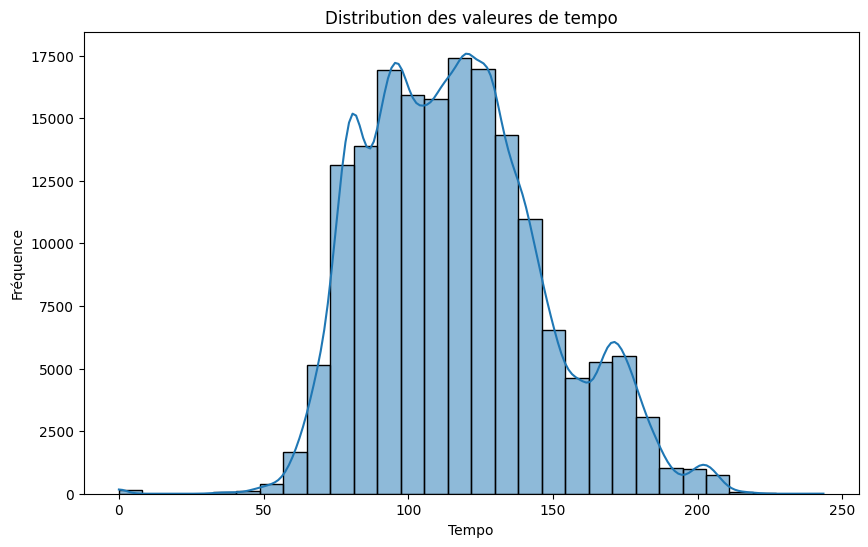

In [7]:
# Variable à expliquer :
plt.figure(figsize=(10, 6))
sns.histplot(data['tempo'], kde=True, bins=30)
plt.title('Distribution des valeures de tempo')
plt.xlabel('Tempo')
plt.ylabel('Fréquence')
plt.show()

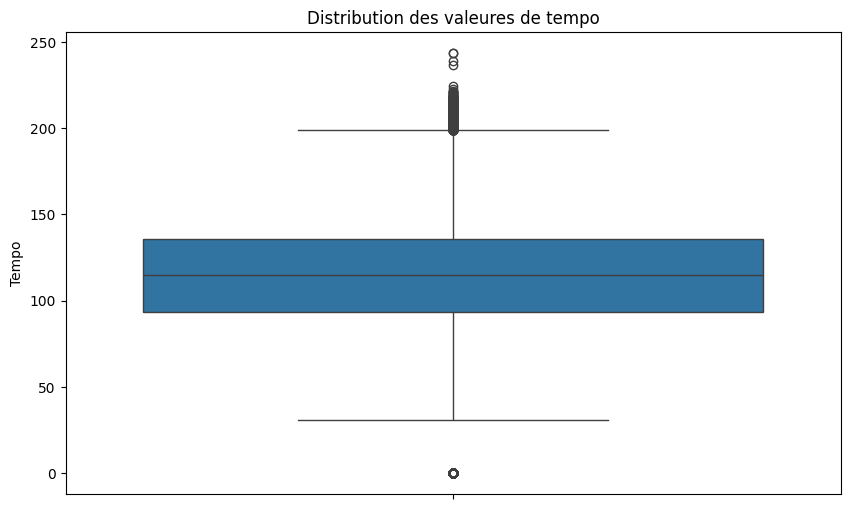

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data['tempo'])
plt.title('Distribution des valeures de tempo')
plt.ylabel('Tempo')
plt.show()

In [9]:
min_tempo_row = data.loc[data['tempo'].idxmin()]
# Afficher la ligne
print(min_tempo_row)

valence                                          0.0
year                                            1924
acousticness                                   0.996
artists                          ['Ignacio Corsini']
danceability                                     0.0
duration_ms                                   133947
energy                                        0.0258
explicit                                           0
id                            2WTtJDfCUjAyCZHRSfCLDn
instrumentalness                               0.768
key                                                5
liveness                                      0.0831
loudness                                     -24.894
mode                                               1
name                La Mina del Ford - Remasterizado
popularity                                         0
release_date                              1924-03-29
speechiness                                      0.0
tempo                                         

Après vérification, il s'agit d'une erreure car le tempo de ce morceau c'est pas de 0. Nous allons donc supprimer cette observation.

In [10]:
data = data.drop(data['tempo'].idxmin())

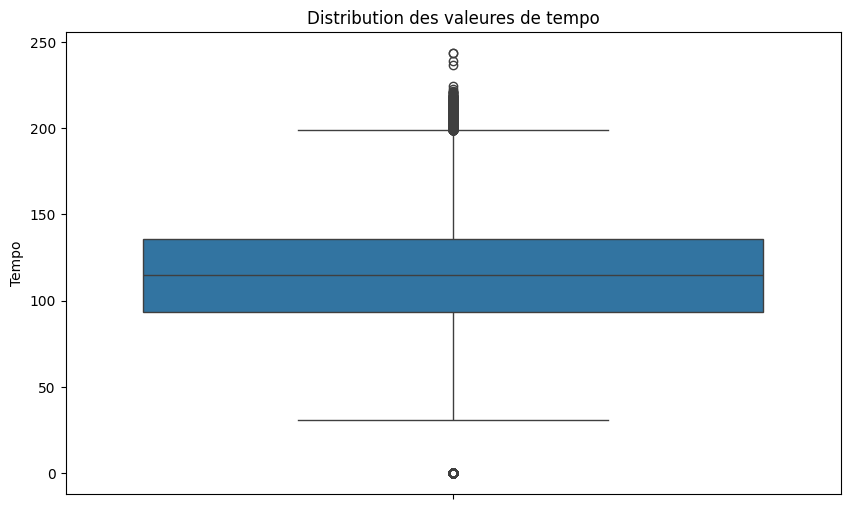

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data['tempo'])
plt.title('Distribution des valeures de tempo')
plt.ylabel('Tempo')
plt.show()

In [12]:
data.loc[data['tempo'].idxmin()]

valence                                        0.0
year                                          1924
acousticness                                 0.996
artists                       ['Francisco Canaro']
danceability                                   0.0
duration_ms                                 170253
energy                                       0.315
explicit                                         0
id                          5tQsQaMquCXBREb1FNymi7
instrumentalness                             0.956
key                                              8
liveness                                     0.375
loudness                                   -15.969
mode                                             0
name                Oh Mujer Mujer - Remasterizado
popularity                                       0
release_date                            1924-07-12
speechiness                                    0.0
tempo                                          0.0
Name: 591, dtype: object

Il reste des musique dont le tempo est égal à 0 et on comprends maintenant qu'il s'agit d'erreures à chaque fois. Nous allons donc supprimer toutes les observations pour lesquelles le tempo vaut 0.

In [13]:
data_no_0 = data.loc[data['tempo'] != 0.0]

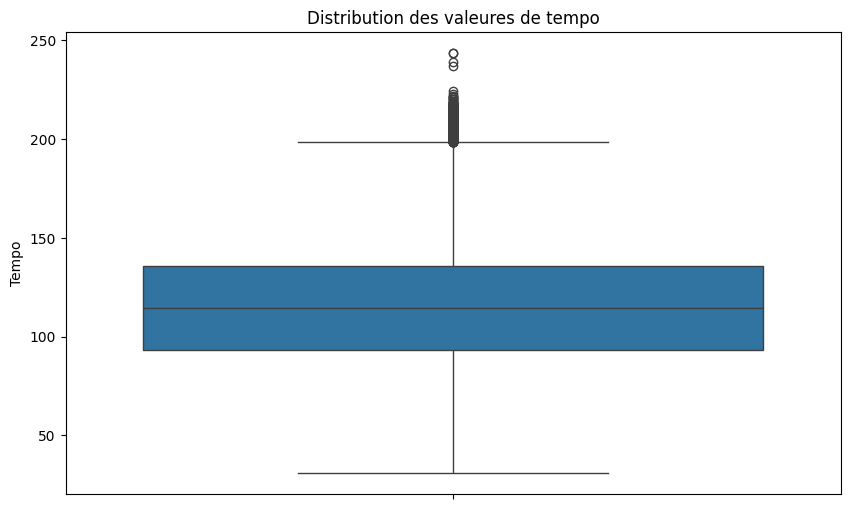

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data_no_0['tempo'])
plt.title('Distribution des valeures de tempo')
plt.ylabel('Tempo')
plt.show()

In [15]:
data_no_0.loc[data_no_0['tempo'].idxmin()]

valence                              0.308
year                                  1965
acousticness                         0.855
artists                    ['Lenny Welch']
danceability                         0.422
duration_ms                         173960
energy                               0.158
explicit                                 0
id                  49TODnGb6Y2wup2Unp2JWC
instrumentalness                       0.0
key                                      8
liveness                             0.117
loudness                            -12.79
mode                                     1
name                  Since I Fell for You
popularity                              20
release_date                          1965
speechiness                         0.0277
tempo                               30.946
Name: 81469, dtype: object

Nous retrouvons bien une musique très lente, vérifions maintenant les tempos les plus élevés. 

In [16]:
max_tempo_row = data_no_0.loc[data_no_0['tempo'].idxmax()]
print(max_tempo_row)

valence                                   0.828
year                                       1972
acousticness                              0.497
artists                        ['Bill Withers']
danceability                              0.535
duration_ms                              277221
energy                                     0.38
explicit                                      0
id                       56n7xjncKs9RInEHAmjtco
instrumentalness                          0.257
key                                          11
liveness                                  0.072
loudness                                 -13.79
mode                                          0
name                I Don't Want You on My Mind
popularity                                   33
release_date                         1972-05-01
speechiness                              0.0497
tempo                                   243.507
Name: 82884, dtype: object


Ici, s'agissant d'un morceau de soul, on est bien loin des 243 bpm, on supprime cette observation.

In [17]:
data_clean = data_no_0.drop(data['tempo'].idxmax())

In [18]:
max_tempo_row2 = data_clean.loc[data_clean['tempo'].idxmax()]

print(max_tempo_row2)

valence                              0.615
year                                  1972
acousticness                         0.198
artists                      ['J.J. Cale']
danceability                         0.466
duration_ms                         147200
energy                               0.188
explicit                                 0
id                  55ROr3cl3yi4YRBgfpDy1d
instrumentalness                     0.657
key                                      1
liveness                             0.082
loudness                           -18.309
mode                                     0
name                       Call The Doctor
popularity                              48
release_date                          1972
speechiness                         0.0547
tempo                              243.372
Name: 29113, dtype: object


Il y a potentiellement beaucoup de morceaux dont le bpm à été surestimé, on va vérifier ceci.

In [19]:
top_20_max_tempo = data_clean.nlargest(20, 'tempo')
pd.DataFrame(top_20_max_tempo)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
29113,0.6150,1972,0.198000,['J.J. Cale'],0.466,147200,0.188000,0,55ROr3cl3yi4YRBgfpDy1d,0.657000,1,0.0820,-18.309,0,Call The Doctor,48,1972,0.0547,243.372
64511,0.4570,1967,0.617000,['Bob Dylan'],0.429,194733,0.225000,0,4xhHhecO7i0jEySdGKQMWp,0.000006,2,0.1120,-15.342,0,Dear Landlord,32,1967-12-27,0.0396,238.895
28559,0.5190,1970,0.261000,['Grateful Dead'],0.332,373970,0.423000,0,4FJ0051ukEptZAhP01ExGV,0.000140,0,0.0716,-12.102,1,Candyman - 2013 Remaster,43,1970-06-01,0.0384,236.799
164226,0.3590,1988,0.084100,['Suicide'],0.157,229840,0.500000,0,0XRX7qxRLh4HFvDqvD1hHV,0.688000,6,0.2230,-14.337,0,Surrender - 2005 Remastered Version,28,1988-01-01,0.0464,224.437
120350,0.0321,1997,0.450000,['Portishead'],0.241,260027,0.281000,0,25G1w3E4OMrovtPE5F510g,0.000007,0,0.0937,-8.726,1,Undenied,45,1997-01-01,0.0416,222.605
2517,0.8410,1934,0.994000,['Bimal Gupta'],0.367,192807,0.293000,0,0lxjAnjTPqtiq4Ehm13LJV,0.921000,4,0.2260,-18.038,1,Biyer Pare,0,1934-12-31,0.1710,221.741
134328,0.3230,1987,0.000003,['Big Black'],0.222,100507,0.889000,1,4RZqXtdJaIYjcNa7LB5cxK,0.228000,4,0.1110,-10.007,0,L Dopa,30,1987-09-10,0.0576,221.112
22909,0.5690,1940,0.978000,['Anestis Delias'],0.455,199933,0.586000,0,0Wn5GwEknF21VJK9KUXnv7,0.897000,1,0.2170,-10.687,1,To xaremi sto xamam,1,1940-01-01,0.0416,221.058
125201,0.5690,1930,0.978000,['Anestis Delias'],0.455,199933,0.586000,0,65FegRCzQ8x1UkLUzXe3CA,0.897000,1,0.2170,-10.687,1,To xaremi sto xamam,0,1930-01-01,0.0416,221.058
21009,0.7960,1931,0.996000,['M. N. Ghosh'],0.364,216893,0.000603,0,284tEstzJkqHjcRF2UreAO,0.935000,1,0.3000,-20.174,1,Din Phuralo Samjhe Chalo,0,1931-12-01,0.0762,220.229


Ici, le tempo de casi tous ces morceaux ont étés sur-estimés. Étant donné que la catégorie de tmpo la plus haute est entre 200-208 bpm (Prestissimo) nous allons supprimer tous les titres excédants cette limite.

In [20]:
data_clean = data_clean.loc[data_clean['tempo'] < 208]

In [21]:
top_20_max_tempo = data_clean.nlargest(20, 'tempo')
pd.DataFrame(top_20_max_tempo)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
75569,0.5140,1928,0.99200,['Paul Whiteman'],0.308,183080,0.0923,0,5RLjO12WmCsfDPsrjwcm6o,0.420000,7,0.0815,-19.751,0,When My Dreams Come True,0,1928,0.0464,207.989
18791,0.0471,2015,0.01230,['A$AP Rocky'],0.485,126960,0.7200,1,1j6kDJttn6wbVyMaM42Nxm,0.000000,6,0.0546,-5.991,1,Lord Pretty Flacko Jodye 2 (LPFJ2),68,2015-05-26,0.1270,207.982
19504,0.2290,2019,0.97900,['Clairo'],0.509,175961,0.0167,0,3zksbXteOCeSusJ5Xltr3t,0.000027,9,0.3870,-24.639,1,Bubble Gum,78,2019-02-22,0.1150,207.970
73754,0.1640,2013,0.71700,['Vampire Weekend'],0.345,237973,0.3130,0,3t87C08isN6yw2DnWOorLm,0.000822,4,0.1000,-10.098,1,Hannah Hunt,55,2013-05-27,0.0681,207.969
27708,0.5270,1965,0.96800,"['Harry Belafonte', 'Miriam Makeba']",0.312,195120,0.0478,0,0eP52OQtijQQzZBXDc923Z,0.000294,5,0.1100,-23.306,1,My Angel (Malaika),38,1965-05-19,0.0402,207.956
131997,0.9650,1976,0.31300,['Silver Convention'],0.628,250253,0.5040,0,4hBqB9ggnSW1a68UVaKqua,0.009760,9,0.2300,-16.117,0,Get Up and Boogie (That's Right),32,1976,0.0510,207.956
162160,0.3470,1978,0.42500,['The Residents'],0.368,144667,0.7140,0,2WbYdb0pGbx90T2TZ83PeF,0.069500,9,0.2580,-5.391,1,Constantinople,23,1978,0.2490,207.949
44220,0.4950,1955,0.84100,['Javier Solís'],0.281,169880,0.3230,0,4hkt0gF3UZkVyeFz1jPXw4,0.000019,2,0.2300,-6.838,0,Angustia,20,1955,0.0312,207.920
78751,0.4510,1952,0.07700,['Эрнест Хемингуэй'],0.599,105500,0.3030,1,0XPPzZxG6nyT076f3JqKDX,0.000000,7,0.1930,-16.623,1,Часть 45.2 - Старик и море,0,1952,0.9620,207.915
163863,0.6480,1986,0.25200,['Cyndi Lauper'],0.540,234880,0.7530,0,5lnnBCTFXgjP2Px2SG5oYZ,0.002210,1,0.1220,-9.150,1,Calm Inside the Storm,33,1986-10-14,0.0662,207.912


Encore que des erreures, on garde maintenant uniquement en dessous de 200 bpm.

In [22]:
data_clean = data_clean.loc[data_clean['tempo'] < 200]
top_20_max_tempo = data_clean.nlargest(20, 'tempo')
pd.DataFrame(top_20_max_tempo)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
132384,0.966,1978,0.001410,['Ramones'],0.331,129293,0.978,0,0VPvLrFJby7clnTauyU8Ah,0.000079,4,0.1550,-1.626,1,I'm Against It - 2018 Remaster,44,1978,0.0397,199.999
54554,0.483,2006,0.040200,['Taylor Swift'],0.459,179067,0.753,0,4pJi1rVt9GNegU9kywjg4z,0.000000,10,0.0863,-3.827,1,Teardrops on My Guitar - Pop Version,49,2006-10-24,0.0537,199.997
102255,0.300,1987,0.669000,['Michael Jackson'],0.386,250773,0.496,0,2O9llQaI7q6FPY2afs9k8R,0.000000,5,0.0649,-7.203,1,Todo Mi Amor Eres Tu (I Just Can't Stop Loving...,42,1987-08-31,0.0643,199.995
68067,0.558,1985,0.891000,['Peter Ivers'],0.576,200773,0.284,0,5Up7kKnSg7Z1YHRToUbZ1p,0.000004,8,0.1330,-10.041,1,Miraculous Weekend,38,1985,0.1210,199.988
36722,0.677,2011,0.000105,"['Brian Tuey', 'James McCawley', 'Kevin Sherwo...",0.366,228160,0.933,0,3lpnYiJSFZmtsIM13OyRfa,0.000002,8,0.1020,-3.808,1,115,64,2011-01-25,0.1720,199.984
146563,0.705,1974,0.324000,['Van Morrison'],0.465,184893,0.801,0,08KsO8YdGRakbdejSE2WSR,0.000161,2,0.9020,-4.730,1,Warm Love - Live,23,1974-01,0.0780,199.984
106464,0.298,2008,0.000101,['DragonForce'],0.138,433920,0.987,0,6BUb5Ti1FO4B1i2iaY7IQQ,0.000380,2,0.3720,-3.368,1,Heroes of Our Time,44,2008-08-23,0.1530,199.983
88432,0.907,2001,0.088400,['Chicos de Barrio'],0.541,273987,0.678,0,618mLnrxxwZNlsWDhip4f0,0.000002,0,0.0851,-8.428,1,Antología de caricias,49,2001-04-23,0.0315,199.981
51739,0.781,1992,0.007680,['Hi-Five'],0.518,275160,0.807,0,2MYtYwqRutASW0oVTYPuEX,0.000000,1,0.2710,-6.680,1,She's Playing Hard To Get,41,1992-08-10,0.0570,199.979
13713,0.751,1990,0.008470,['Hi-Five'],0.525,276573,0.811,0,3xRbymJj98leHL7K8Y94WS,0.000000,1,0.2660,-6.148,1,She's Playing Hard To Get,54,1990,0.0602,199.977


Il y a encore énormément d'erreures, on descend maintenant sous les 168 bpm.

In [23]:
data_clean = data_clean.loc[data_clean['tempo'] < 168]
top_20_max_tempo = data_clean.nlargest(20, 'tempo')
pd.DataFrame(top_20_max_tempo)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
2267,0.854,1933,0.927000,['Billie Holiday'],0.609,132667,0.275,0,5RoFhYeti1NVygCpDqv4Xz,0.000048,0,0.1000,-11.307,1,Trav'lin' All Alone,20,1933,0.0974,167.999
3142,0.854,1937,0.927000,['Billie Holiday'],0.609,132667,0.275,0,1hUdgLMmAp22rRcvXK6OTl,0.000048,0,0.1000,-11.307,1,Trav'lin' All Alone,3,1937,0.0974,167.999
107326,0.542,2013,0.754000,['C418'],0.523,310000,0.456,0,4K0odcECsBvgzv9Lr9z4kd,0.915000,4,0.0966,-13.393,0,Aria Math,54,2013-11-09,0.0623,167.999
108225,0.220,2017,0.405000,['Camila Cabello'],0.393,221881,0.555,0,3NgCzSW98SsqBdpYcnm4kv,0.000000,10,0.1050,-6.096,0,I Have Questions,66,2017-05-21,0.2760,167.999
15543,0.683,1999,0.231000,['Backstreet Boys'],0.630,234960,0.625,0,3BsaRV5QIulYz2lV9WWa8T,0.000000,6,0.0765,-5.088,0,Show Me the Meaning of Being Lonely,68,1999-05-18,0.0252,167.998
37452,0.700,2014,0.126000,['Tim McGraw'],0.468,235387,0.904,0,3LbvNFkqDTrE1liGMmZBDL,0.000004,7,0.1650,-4.574,1,Shotgun Rider,58,2014-01-01,0.0494,167.998
74557,0.342,2017,0.502000,"['Verzache', 'Swell']",0.524,230000,0.274,0,1olz3HctPa2yXmSniaCNLN,0.257000,6,0.0924,-13.931,1,Waiting for You,64,2017-06-16,0.2950,167.998
168730,0.796,2011,0.212000,['Nelly'],0.548,189000,0.883,0,59qnU7ACYRFKQ2O35D5Onb,0.000000,6,0.0828,-4.697,1,The Champ,45,2011-12-20,0.0766,167.998
19037,0.288,2017,0.006710,['Imagine Dragons'],0.605,187147,0.822,0,1zB4vmk8tFRmM9UULNzbLB,0.134000,0,0.1470,-4.833,1,Thunder,84,2017-06-23,0.0438,167.997
48779,0.783,1977,0.542000,['Vicente Fernández'],0.404,169627,0.459,0,2oZtdBZX75UwUl0IewSbAO,0.000005,9,0.1150,-6.484,1,De Que Tamaño Me Quieres,39,1977,0.0410,167.996


Après vérification, les tempos correspondent maintenant. Nous travaillerons ainsi sur cette base de données avec des tempos n'excédents pas 168. Voici donc la nouvelle distribution. 

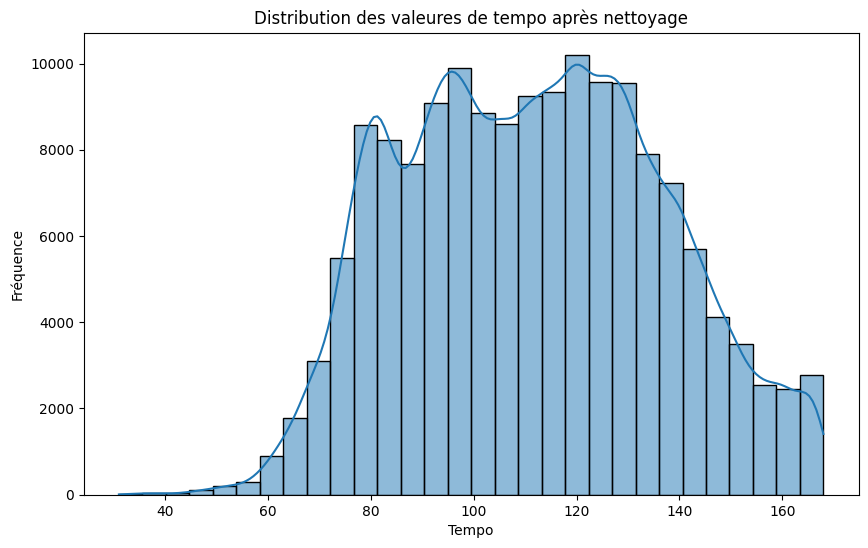

In [24]:
# Variable à expliquer :
plt.figure(figsize=(10, 6))
sns.histplot(data_clean['tempo'], kde=True, bins=30)
plt.title('Distribution des valeures de tempo après nettoyage')
plt.xlabel('Tempo')
plt.ylabel('Fréquence')
plt.show()

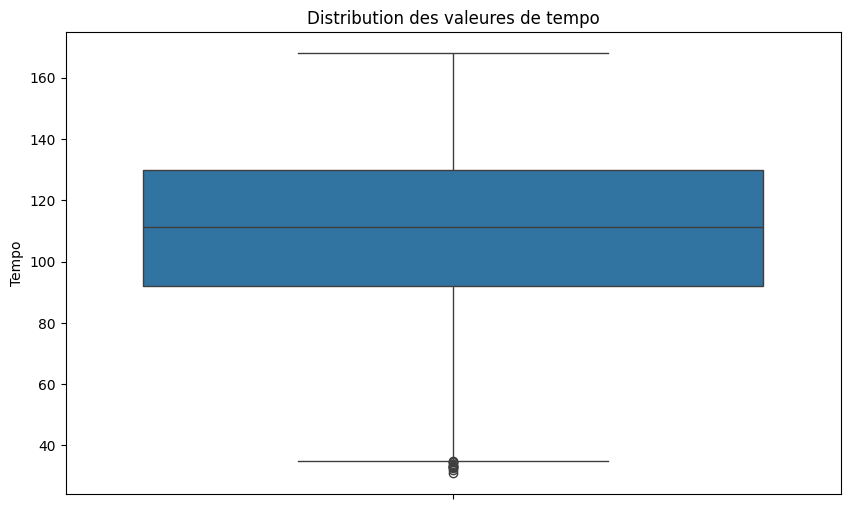

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data_clean['tempo'])
plt.title('Distribution des valeures de tempo')
plt.ylabel('Tempo')
plt.show()

Les morceaux au faible bpm sont les plus rares maintenant que les plus hauts ont étés retirés. La majorité des morceaux sont entre 80 et 130 pusations par minutes.

## Variables explicatives :

### Variant entre O et 1 :

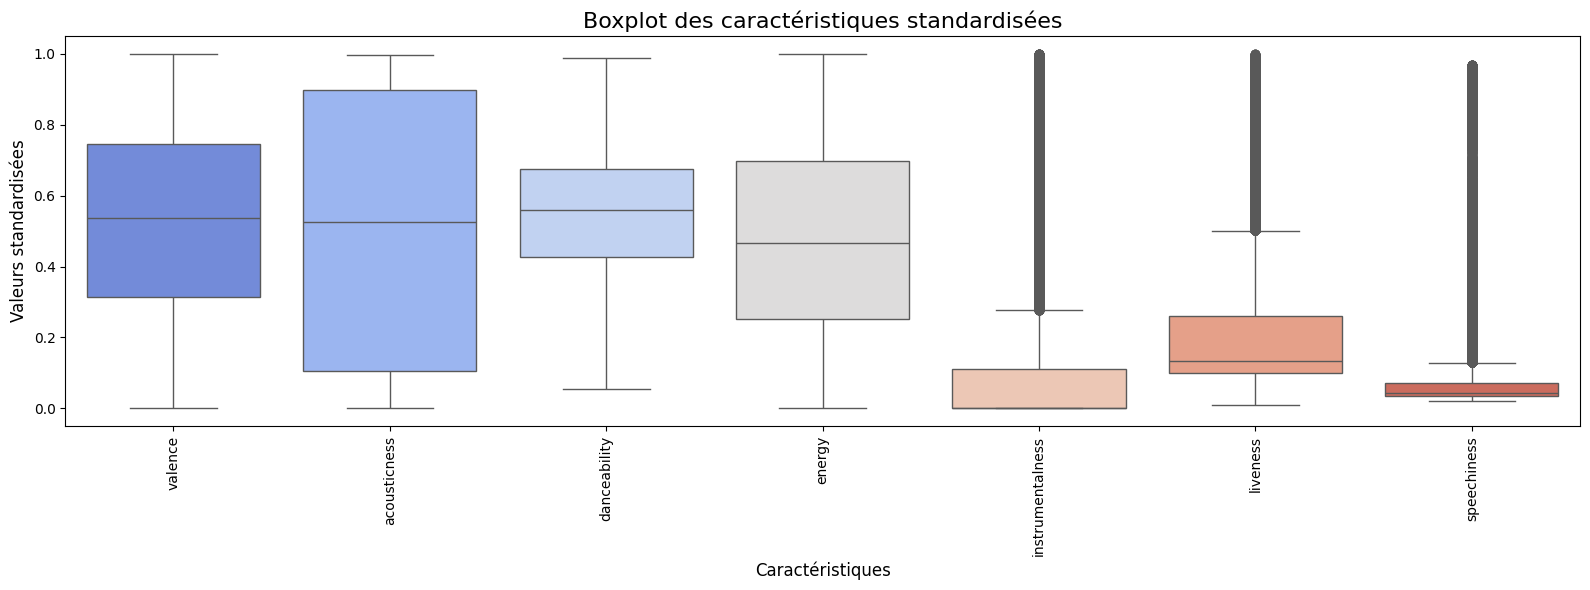

In [33]:
# On créer le vecteur qui contuient les variables qui varient entre 0 et 1
variables_0_1 = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness']

plt.figure(figsize=(16, 6))  # Taille de la figure
sns.boxplot(data=data_clean[variables_0_1], palette="coolwarm")  # Utilisation correcte des données
plt.title("Boxplot des caractéristiques standardisées", fontsize=16)
plt.xlabel("Caractéristiques", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Valeurs standardisées", fontsize=12)
plt.tight_layout()
plt.show()

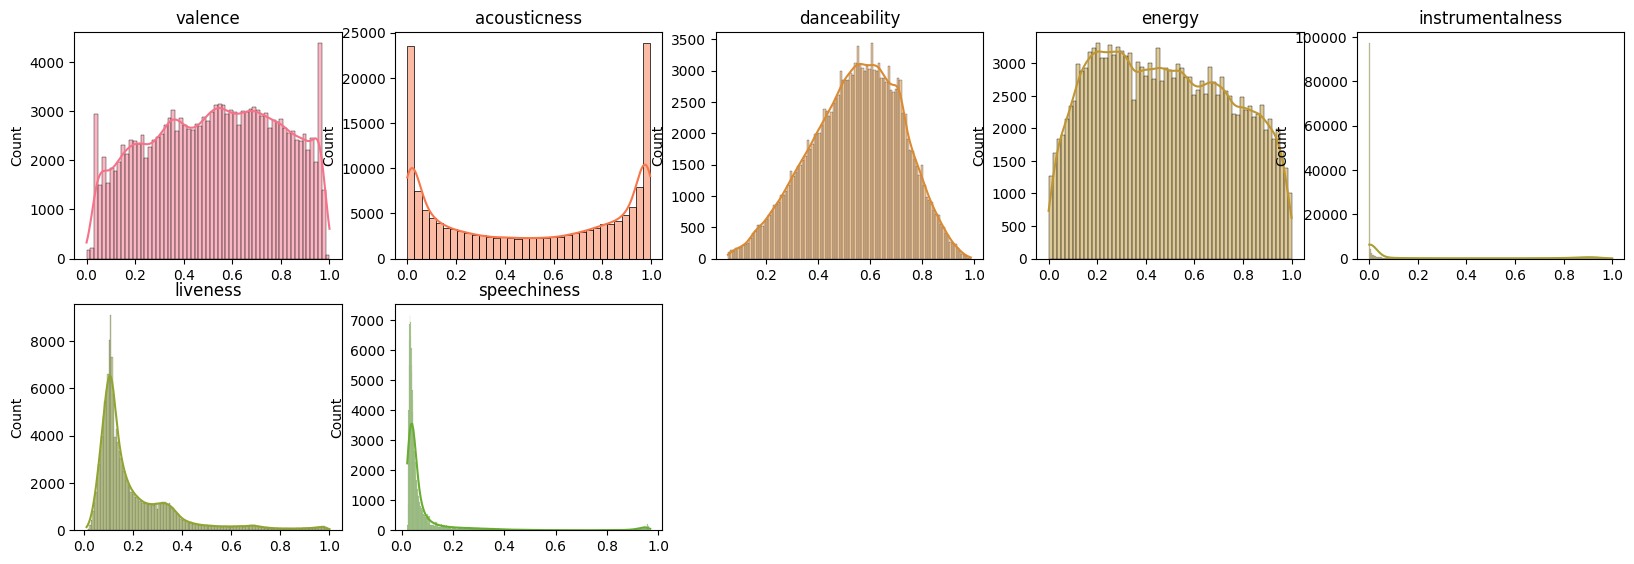

In [28]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette("husl", len(data_clean.columns))
for i, column in enumerate(data_clean[variables_0_1].columns):
    plt.subplot(3, 5, i+1)
    sns.histplot(data_clean[column], kde=True, color=colors[i])
    plt.xlabel("", fontsize=0)
    plt.title(column)

On observe que la plupars des morceaux ne sont pas uniquements instrumentaux et ne contiennent pas beacoup de mots 'parlés' (pas chantés). Il y a de nombreux norceaux soit entièrement acoustiques ou pas du tout avec certains entre les deux. L'energie et la valence ont des distributions similaires et uniforméments réparties tandis que la dansabilité semble presque normalement distribuée. 

### Autres variables quantitatives (on considère la tonalité comme quantitative)

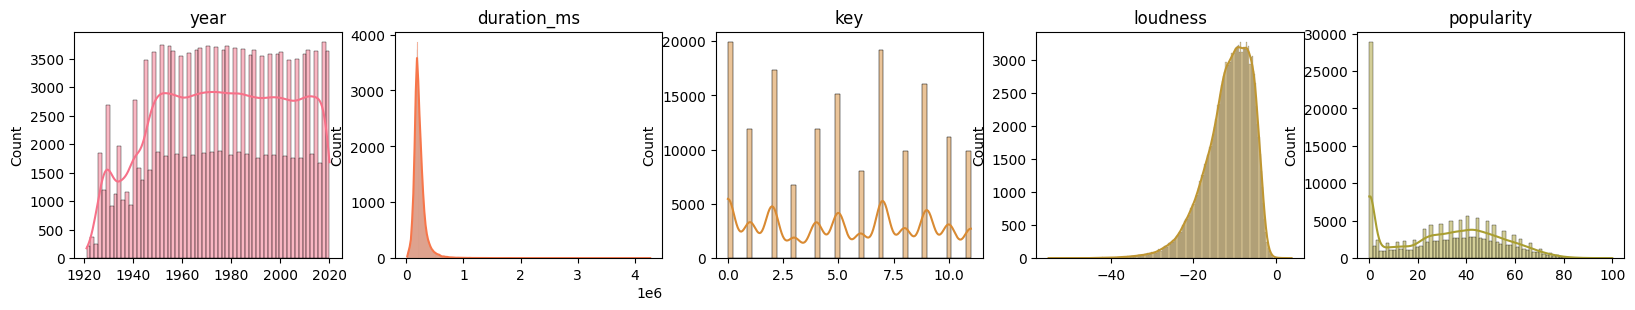

In [29]:
# Liste des autres variables quantitatives
other_quantitative_vars = ['year', 'duration_ms', 'key', 'loudness', 'popularity']

# Histogrammes des autres variables quantitatives
plt.figure(figsize=(20, 10))
colors = sns.color_palette("husl", len(data_clean.columns))
for i, column in enumerate(data_clean[other_quantitative_vars].columns):
    plt.subplot(3, 5, i+1)
    sns.histplot(data_clean[column], kde=True, color=colors[i])
    plt.xlabel("", fontsize=0)
    plt.title(column)

Les histogrammes montrent une augmentation du nombre de morceaux enregistrés depuis les années 1950, une majorité de morceaux courts (autour de 3-5 minutes), malgré des outliers avec certains morceaux très longs, et un volume sonore concentré entre -20 dB et -5 dB. La tonalité est répartie de manière inégale, reflétant une diversité musicales. La popularité est fortement biaisée vers les valeurs faibles, avec peu de morceaux très populaires.

### Variables quantitatives :

/var/folders/jq/dwvfq6hd6cb00_ztp8scl1_h0000gn/T/ipykernel_917/3399368607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x=var, palette="pastel")
/var/folders/jq/dwvfq6hd6cb00_ztp8scl1_h0000gn/T/ipykernel_917/3399368607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x=var, palette="pastel")


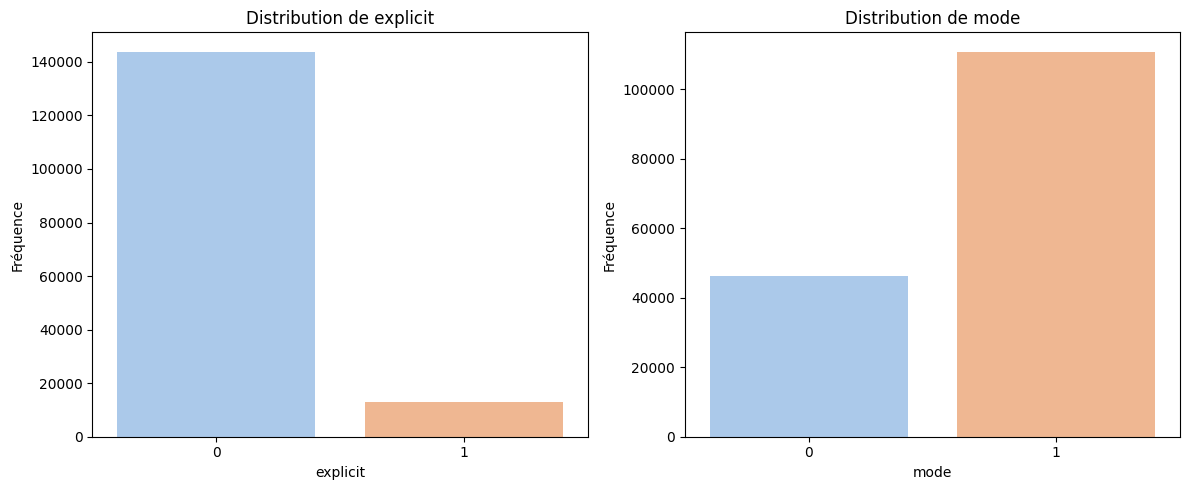

In [30]:
# Liste des variables qualitatives restantes
qualitative_vars = ['explicit', 'mode']

# Création de la figure
plt.figure(figsize=(12, 5))

for i, var in enumerate(qualitative_vars, 1):
    plt.subplot(1, 2, i)  # Disposition en une seule ligne avec deux colonnes
    sns.countplot(data=data_clean, x=var, palette="pastel")
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel('Fréquence')

plt.tight_layout()  # Ajuste automatiquement l'espacement
plt.show()

La grande majorité des titres ne sont pas explicites (moins de 20 000) et la plupars sont aussi en tonalité majeure (plus de 100 000).

### Transformation de la target en variable catégorielle :

In [26]:
# Catégorisation selon des plages définies manuellement
indicateurs_tempo = [0, 40, 60, 66, 76, 108, 120, 160, 168]

labels = ['A tempo', 'Largo', 'Larghetto', 'Adagio', 'Andante', 'Moderato', 'Allegro', 'Presto']
data_clean['cate_tempo'] = pd.cut(data_clean['tempo'], bins=indicateurs_tempo, labels=labels, right=False)
data_clean.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,cate_tempo
113441,0.3510,1963,0.666000,['John Coltrane'],0.434,223720,0.4230,0,3H0PO78HK1D0nh3DkGbXGA,0.000114,0,0.1130,-12.518,1,Greensleeves - Take 5,21,1963,0.0316,81.674,Andante
142923,0.3560,1954,0.972000,"['Hector Berlioz', 'Fritz Reiner']",0.552,132933,0.1840,0,0OCvp3xTiNi8hrwlLDxNXz,0.000014,2,0.1120,-14.986,1,"Les nuits d'été, Op. 7: Villanelle",0,1954,0.0543,127.889,Allegro
34758,0.7510,2001,0.000031,['Andrew W.K.'],0.461,184907,0.9940,0,0E0bZtTG39K95uRjqBo1Mx,0.000010,4,0.1560,-3.413,1,Party Hard,58,2001-01-01,0.0429,162.171,Presto
97966,0.0427,1966,0.899000,"['Ludwig van Beethoven', 'Leonard Bernstein', ...",0.193,917907,0.0627,0,6XWVRrSMzpLIzDZBcOCdna,0.740000,0,0.0768,-18.932,0,"Symphony No. 3 in E-Flat Major, Op. 55 ""Eroica...",19,1966,0.0426,112.800,Moderato
96626,0.6770,1959,0.845000,['Howard Roberts'],0.398,162173,0.3800,0,3j2zBlflrrgHAeWjmuh8fP,0.346000,8,0.0993,-13.229,1,All The Things You Are,16,1959-01-01,0.0345,114.923,Moderato


Certaines catégories de tempo se chevauchent légèrement, ce qui peut prêter à confusion lorsque l’on tente de les assigner de manière stricte. Pour éviter que certains tempos n’appartiennent à deux catégories, certaines plages ont dû être ajustées et découpées afin de garantir une classification claire et distincte pour chaque tempo. Par exemple, Presto comprend seulement les bpm de 160 à 168 dans notre cas, alors que sa plage est normalement de 140 à 200.

/var/folders/jq/dwvfq6hd6cb00_ztp8scl1_h0000gn/T/ipykernel_855/2241700847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x='cate_tempo', palette="pastel")


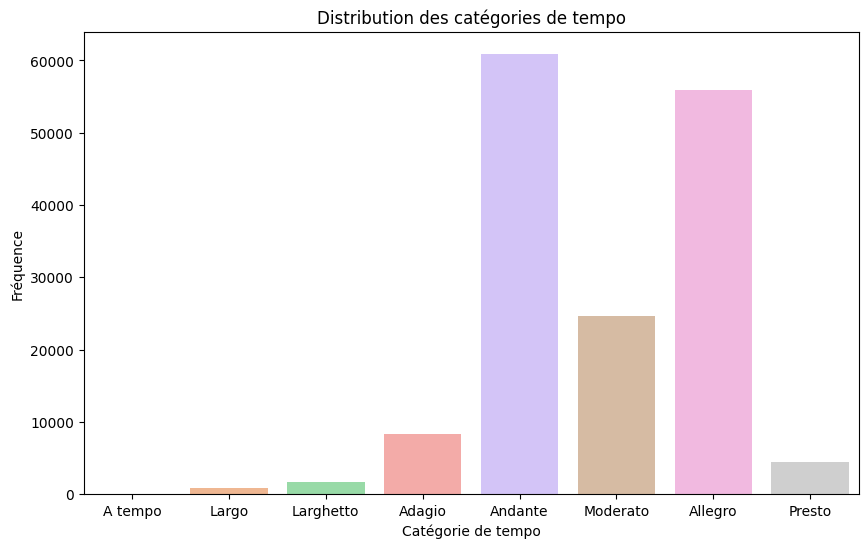

In [27]:
# Représentation de la variable catégorielle
plt.figure(figsize=(10, 6))
sns.countplot(data=data_clean, x='cate_tempo', palette="pastel")
plt.title('Distribution des catégories de tempo')
plt.xlabel('Catégorie de tempo')
plt.ylabel('Fréquence')
plt.show()

L'histogramme présenté si-dessus laisse apparaitre d'importants déséquilibres dans la répartition des morceaux en catégories de tempo. Ainsi, nous choissisons de regrouper les bpm en 3 grands groupes :
	•	Lent : 0-80 BPM
	•	Moyen : 80-120 BPM
	•	Rapide : 120-168 BPM

In [28]:
data_clean = data_clean.drop(columns=['cate_tempo'])

# Catégorisation selon des plages définies manuellement
indicateurs_tempo = [0, 80, 120, 168]

labels = ['Lent', 'Moyen', 'Rapide']
data_clean['cate_tempo'] = pd.cut(data_clean['tempo'], bins=indicateurs_tempo, labels=labels, right=False)
data_clean.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,cate_tempo
4833,0.0767,1946,0.99100,"['Frédéric Chopin', 'Arthur Rubinstein']",0.348,260827,0.0282,0,4G8x0lpxuJ8upWvSntxIZs,0.906000,3,0.1080,-25.113,1,"Nocturnes, Op. 9: No. 2 in E-Flat Major. Andante",27,1946,0.0405,65.703,Lent
152246,0.6050,2003,0.00430,['John Mayer'],0.677,253560,0.8260,0,4UoJ14X24nu9YGwE1r0JOy,0.038500,0,0.1110,-3.106,1,Home Life,41,2003-09-09,0.0245,105.982,Moyen
155596,0.6660,1930,0.79800,['H.P. Lovecraft'],0.651,132100,0.5030,0,75bklE4OjL3BtrHmiCqYpO,0.000000,6,0.1400,-15.698,1,Capítulo 4.4 - el Que Susurraba en la Oscuridad,0,1930,0.9560,89.061,Moyen
32367,0.3870,1989,0.00272,['Faith No More'],0.545,313573,0.9190,0,20nb0Wl1yqoEERbUSILuG1,0.005110,2,0.0977,-7.679,1,Falling to Pieces,51,1989,0.0484,104.366,Moyen
103096,0.7370,1992,0.31400,['Don McLean'],0.466,223200,0.5470,0,3sT8Pu1fKLh8dwYUy52hg1,0.000053,4,0.2820,-11.597,1,Castles In The Air,43,1992-01-01,0.0373,84.363,Moyen


/var/folders/jq/dwvfq6hd6cb00_ztp8scl1_h0000gn/T/ipykernel_917/2241700847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x='cate_tempo', palette="pastel")


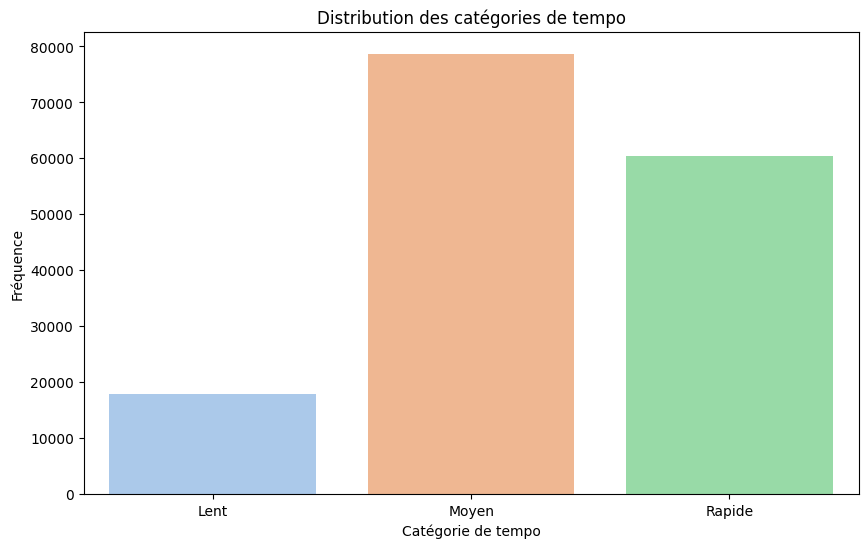

In [34]:
# Représentation de la variable catégorielle
plt.figure(figsize=(10, 6))
sns.countplot(data=data_clean, x='cate_tempo', palette="pastel")
plt.title('Distribution des catégories de tempo')
plt.xlabel('Catégorie de tempo')
plt.ylabel('Fréquence')
plt.show()

Les catégories sont plus homogène malgré trop peu de morceaux lents. Nous utiliserons alors une stratégie de resampling.

In [29]:
# Encodage de la Target
label_encoder = LabelEncoder()
data_clean['cate_tempo'] = label_encoder.fit_transform(data_clean['cate_tempo'])

### Analyse bivariée :

In [30]:
# On commence par sélectionner les variables explicatives utilisées pour la prédiction
feature_names = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'popularity']
X = data_clean[feature_names]
y = data_clean['cate_tempo']

# On concatène les deux DataFrames
df = pd.concat([X, y], axis=1)

In [31]:
# Corrélation entre les variables utilisées pour la prédiction ainsi que la target
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,popularity,cate_tempo
valence,1.000000,-0.026348,-0.169778,0.558941,-0.198439,0.369658,-0.018995,-0.171075,0.027429,-0.007833,0.269124,0.009582,0.134581,0.009840,0.152830
year,-0.026348,1.000000,-0.628894,0.208743,0.258293,0.537418,0.232700,-0.287772,0.007680,-0.104520,0.549828,-0.034737,-0.060535,0.863436,0.150039
acousticness,-0.169778,-0.628894,1.000000,-0.253422,-0.235610,-0.758914,-0.236408,0.297107,-0.018878,0.020393,-0.599040,0.043663,-0.040575,-0.577424,-0.232860
danceability,0.558941,0.208743,-0.253422,1.000000,-0.098937,0.240518,0.247811,-0.293409,0.024415,-0.116849,0.253292,-0.047041,0.253732,0.207033,0.102303
duration_ms,-0.198439,0.258293,-0.235610,-0.098937,1.000000,0.178677,-0.034037,0.108493,-0.001600,-0.066762,0.123741,-0.065633,-0.091925,0.229169,0.033277
energy,0.369658,0.537418,-0.758914,0.240518,0.178677,1.000000,0.132724,-0.224458,0.027501,0.064730,0.813815,-0.041034,0.106309,0.487578,0.253296
explicit,-0.018995,0.232700,-0.236408,0.247811,-0.034037,0.132724,1.000000,-0.235312,0.004799,0.054046,0.168115,-0.079239,0.342064,0.192872,0.014861
instrumentalness,-0.171075,-0.287772,0.297107,-0.293409,0.108493,-0.224458,-0.235312,1.000000,-0.011195,-0.057261,-0.341702,-0.040723,-0.091463,-0.298372,-0.075979
key,0.027429,0.007680,-0.018878,0.024415,-0.001600,0.027501,0.004799,-0.011195,1.000000,-0.003936,0.018395,-0.114497,0.033022,0.007475,0.001403
liveness,-0.007833,-0.104520,0.020393,-0.116849,-0.066762,0.064730,0.054046,-0.057261,-0.003936,1.000000,0.029508,0.002555,0.113184,-0.115326,-0.004966


Aucune variable explicative n'est fortement corrélée avec la target. Les plus corrélés sont la mesure de l'acoustique (plus c'est accoustique moins c'est rapide).
Concernant les corréations entre variaboes explicatives, nous observons que les morceaux les plus populaires sont les plus récents, les plus énergétiques sont ceux ayant une amplitude de volume faible et qui ne sont pas acoustiques.

# Modélisation :

## Créations de nos randoms forest

### Sans resampling :

In [32]:
# S&paration des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Sans tuning ni resampling
rf = RandomForestClassifier(random_state=42)

# Entraînement du modèle
rf.fit(X_train, y_train)

cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Moyenne des scores de la CV : {cv.mean():.3f}')
print(f'Écart-type des scores de la CV : {cv.std():.3f}')

Moyenne des scores de la CV : 0.583
Écart-type des scores de la CV : 0.001


In [55]:
# Avec tuning, sans resampling
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = GridSearchCV(estimator = rf, param_grid=param_grid, cv=2, verbose=1, n_jobs=-1)

random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print(f"Meilleur score : {random_search.best_score_:.2f}")

# Entraîner le modèle avec les meilleurs hyperparamètres
best_rf = random_search.best_estimator_

# Meilleurs hyperparamètres : 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False

Fitting 2 folds for each of 432 candidates, totalling 864 fits


KeyboardInterrupt: 

Refaire tourner le random search est trop long, on estime le modèle rf manuellement avec les meilleurs paramètres :

In [34]:
#Meilleure modèle rf
rf = RandomForestClassifier(
     n_estimators= 300, 
     min_samples_split= 5, 
     min_samples_leaf= 2, 
     max_features = 'sqrt', 
     max_depth= None, 
     bootstrap = False 
 )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)

In [35]:
#Si nous tournons uniquement le meilleur modèle
best_rf = rf
# Prédictions sur les données de test
y_pred = best_rf.predict(X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Rapport de classification
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.21      0.31      3567
           1       0.60      0.76      0.67     15818
           2       0.59      0.50      0.55     12012

    accuracy                           0.60     31397
   macro avg       0.60      0.49      0.51     31397
weighted avg       0.60      0.60      0.58     31397



Le modèle sans réequilibre des classes présente des performances plutôt mauvaises quant à la prédiction de la classe minoritaire. En effet, ce dernier prédit seulemeent 21% de vrais positifs de la classe 0 (musiques lentes). De plus seulement un vrai positif sur deux est détecté pour les musiques rapides (classe 2). Globalement, le modèle obtien 60% de précision. On en déduis alors la nécessité d'effectuer un resampling. 

### Avec resampling :

Maintenant, nous allons rééquilibrer notre jeu de données au niveau des classes de la target. Étant donné que le jeu de donnée contient plus de 170 000 observations cela entraine une complexité computationelle importante. Ainsi, nous choisissons d'utiliser une stratégie d'undersampling qui va permettre de réduire la taille du dataset, de le rééquilibrer tout en conservant suffisemment d'observations.

In [42]:
# Initialisation de l'undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Application de l'undersampling
X_train_rs, y_train_rs = undersampler.fit_resample(X_train , y_train)
y_train_rs = y_train_rs.squeeze()
y_train_rs = pd.DataFrame({'cate_tempo': y_train_rs})
X_train_rs = pd.DataFrame(X_train_rs, columns=feature_names)

y_train_rs.sample(10)

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,cate_tempo
41179,2
160668,1
86744,1
49914,2
66718,2
132744,2
120452,2
157706,1
59143,1
73639,0


/var/folders/jq/dwvfq6hd6cb00_ztp8scl1_h0000gn/T/ipykernel_917/288791058.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=y_train_rs, x='cate_tempo', palette='Set2')


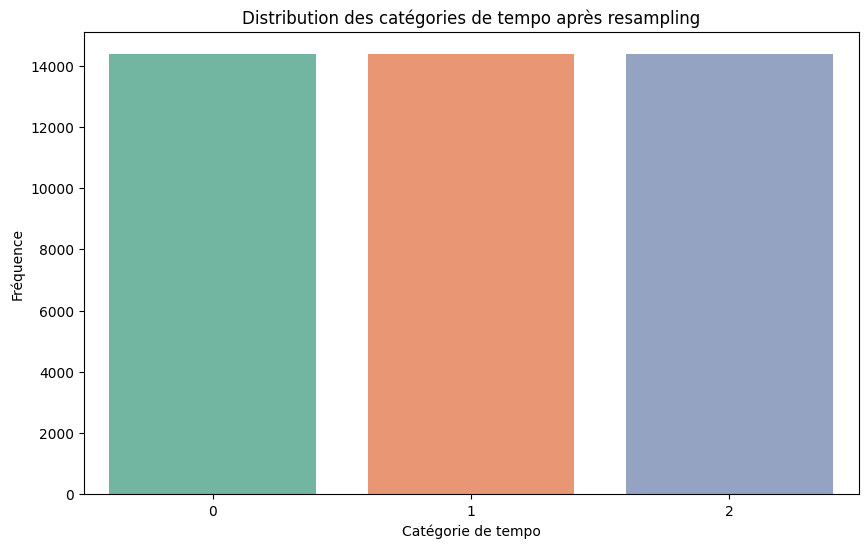

In [43]:
# Représentation de la variable catégorielle
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train_rs, x='cate_tempo', palette='Set2')
plt.title('Distribution des catégories de tempo après resampling')
plt.xlabel('Catégorie de tempo')
plt.ylabel('Fréquence')
plt.show()

Maintenant que le jeu de donnée est équilibré, on retente un modèle de random forest.

In [44]:
rf.fit(X_train_rs, y_train_rs)

# Sans tuning
cv = cross_val_score(rf, X_train_rs, y_train_rs.values.ravel(), cv=5, scoring='accuracy')
print(f'Moyenne des scores de la CV : {cv.mean():.3f}')
print(f'Écart-type des scores de la CV : {cv.std():.3f}')

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Moyenne des scores de la CV : 0.545
Écart-type des scores de la CV : 0.004


Le modèle sans tuning mais resamplé est un petit peu moins précis que celui sans tuning ni resampling.

In [44]:
# Avec tuning, avec resamplin
param_grid = {
    'n_estimators': [250, 300, 350, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=-2)

random_search.fit(X_train_rs, y_train_rs.values.ravel())

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print(f"Meilleur score : {random_search.best_score_:.2f}")

# Entraîner le modèle avec les meilleurs hyperparamètres
best_rf_rs = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs hyperparamètres :  {'n_estimators': 350, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Meilleur score : 0.55


In [45]:
#Meilleure modèle rf_tuné
rf_tuné = RandomForestClassifier(
     n_estimators= 350, 
     min_samples_split= 3, 
     min_samples_leaf= 2, 
     max_features = 'sqrt', 
     max_depth= 20, 
     bootstrap = True 
 )

rf_tuné.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=350)

In [46]:
#Si nous tournons uniquement le meilleur modèle
best_rf_rs = rf_tuné
# Prédictions sur les données de test
y_pred2 = best_rf_rs.predict(X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy:.2f}')

# Rapport de classification
class_report = classification_report(y_test, y_pred2)
print('Classification Report:')
print(class_report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred2)

Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.18      0.27      3567
           1       0.59      0.77      0.67     15818
           2       0.59      0.48      0.53     12012

    accuracy                           0.59     31397
   macro avg       0.60      0.48      0.49     31397
weighted avg       0.59      0.59      0.57     31397



Le modèle avec rééquilibrage des classes présente des performances relativement faibles, notamment pour la prédiction de la classe minoritaire. En effet, il ne détecte que 18 % des vrais positifs pour la classe 0 (musiques lentes). Par ailleurs, pour la classe 2 (musiques rapides), un peu moins qu'un un vrai positif sur deux est correctement identifié. Dans l’ensemble, le modèle atteint une précision globale de 59 %. Ces résultats indiquent que, malgré le resampling, le modèle ne montre pas d’amélioration significative en termes de performance.

Par conséquent, pour l’interprétation du modèle, nous choisissons de retenir le premier modèle, entraîné sans rééquilibrage des classes. Ce dernier présente une complexité moindre et des performances légèrement supérieures.

# Interprétation du modèle

## Interprétation global du modèle

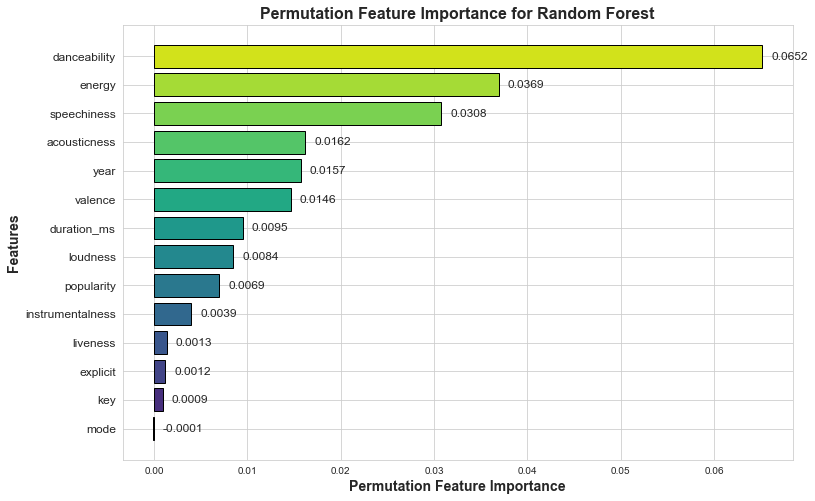

In [66]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import numpy as np
sns.set_style("whitegrid")
result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = np.argsort(result.importances_mean)
plt.figure(figsize=(12, 8))
plt.barh(
    np.arange(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    align='center', 
    color=sns.color_palette("viridis", len(sorted_idx)),  # Palette de couleurs dynamiques
    edgecolor='black'
)
plt.yticks(np.arange(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx], fontsize=12)
plt.xlabel('Permutation Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.title('Permutation Feature Importance for Random Forest', fontsize=16, fontweight='bold')
for i, v in enumerate(result.importances_mean[sorted_idx]):
    plt.text(v + 0.001, i, f"{v:.4f}", fontsize=12, verticalalignment="center")

plt.show()

La représentation graphique ci-dessus nous permet de comprendre l’importance relative des différentes variables dans la prévision du type de tempo (lent, moyen ou rapide), à l’aide d’un modèle de forêt aléatoire. En analysant cet histogramme, on observe que la variable danceability (dansabilité) est la plus influente dans notre modèle, avec un score de 0,065.

Les variables energy et speechiness apparaissent également comme significatives, avec des scores respectifs de 0,0369 et 0,0308. En troisième position, on retrouve les variables acousticness, year et valence, qui semblent également jouer un rôle non négligeable.

Ainsi, les caractéristiques liées à la dynamique et à la structure sonore d’un morceau semblent déterminantes pour la prévision du tempo. Néanmoins, il est important de noter que même la variable la plus influente présente un score inférieur à 0,5. Cela suggère que d’autres variables, non prises en compte dans notre modèle actuel, pourraient être pertinentes à intégrer afin d’améliorer sa performance.

Dans le cadre de la poursuite de notre analyse globale du modèle et notamment la visualisation du graphique de dépendance partielle pour chaque type de tempo (lent, moyen ou rapide), nous choisissons de ne visualiser que les cinq variables les plus importantes identifiées dans cette étude.

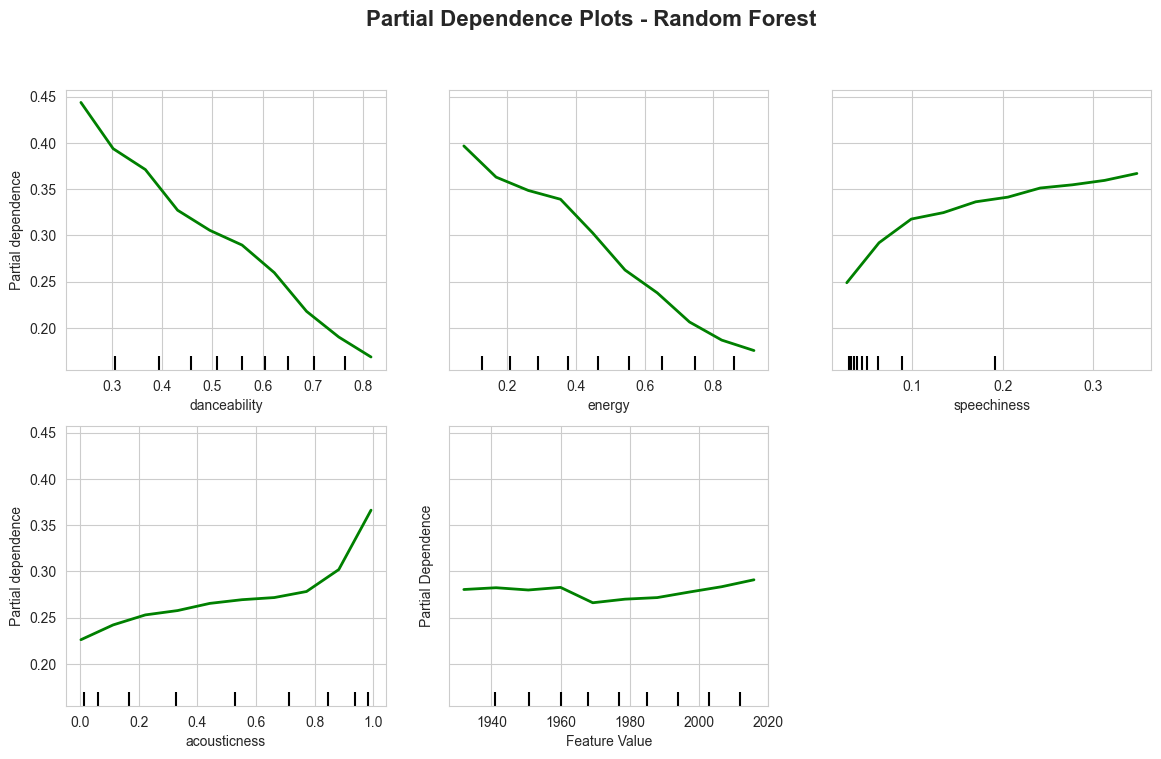

In [56]:
#PDP [0]
from sklearn.inspection import PartialDependenceDisplay
sns.set_style("whitegrid")

features = ['danceability', 'energy', 'speechiness', 'acousticness', 'year']

fig, ax = plt.subplots(figsize=(14, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf,                        
    X_train,
    features,
    grid_resolution=10,             
    subsample=50,                   
    n_jobs=-1,                      
    target=0,
    ax=ax,
    line_kw={"color": "blue", "linewidth": 2},
    pd_line_kw={"color": "green", "linewidth": 2}
)

plt.suptitle('Partial Dependence Plots - Random Forest', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.88)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.show()

Les Partial Dependence Plots du labels lents, représnete l'effet marginal de chaque variable sur la prédiction du modèle, sous la contrainte du maintien des autres variables constantes.

Au vu des différents résultats, Nous pouvons observer que plus un morceau est dansant ("danceability") ou énergique ("energy"), moins il a de chances d’être lent, ce qui est cohérent avec l’idée que les morceaux rythmés sont souvent plus rapides. À l’inverse, une grande présence de paroles parlées ("speechiness") et une texture acoustique ("accousticness") marquée augmentent la probabilité d’un tempo lent, reflétant des morceaux plus calmes comme le spoken word ou les ballades acoustiques. Enfin, les morceaux plus récents ont une légère tendance à être plus lents, bien que cet effet soit moins marqué.

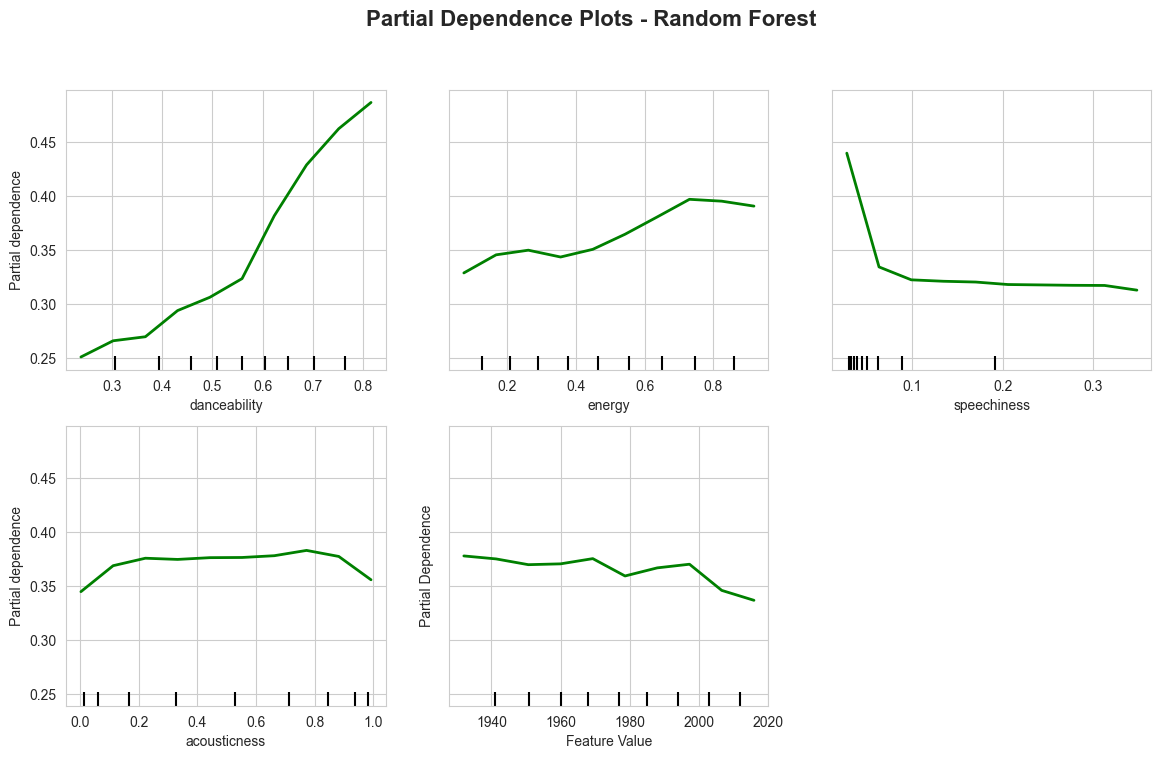

In [57]:
#PDP [1]
from sklearn.inspection import PartialDependenceDisplay
sns.set_style("whitegrid")

features = ['danceability', 'energy', 'speechiness', 'acousticness', 'year']

fig, ax = plt.subplots(figsize=(14, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf,                        
    X_train,
    features,
    grid_resolution=10,             
    subsample=50,                   
    n_jobs=-1,                      
    target=1,
    ax=ax,
    line_kw={"color": "blue", "linewidth": 2},
    pd_line_kw={"color": "green", "linewidth": 2}
)

plt.suptitle('Partial Dependence Plots - Random Forest', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.88)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.show()

Ce graphique nous met également en évidence les variables qui influencent la probabilité qu’un morceau soit classé avec un tempo moyen c'est à dire entre 80 et 120 bpm. Contrairement au cas précédent, la danceability a ici un effet fortement positif : plus un morceau est dansant, plus il est probable qu’il ait un tempo moyen, ce qui est cohérent avec l’expérience musicale. De même, l’énergie a une influence globalement croissante, bien que moins marquée, suggérant que les morceaux plus dynamiques sont plus souvent moyen. À l’inverse, la speechiness présente une forte relation négative : les morceaux avec plus de paroles parlées sont moins susceptibles d’avoir un tempo moyen.

La variable acousticness montre une courbe légèrement convexe, mais reste globalement plate, suggérant une influence modérée : les morceaux très acoustiques semblent légèrement moins associés aux tempos moyen. Enfin, la variable year affiche une tendance décroissante, indiquant que les morceaux plus récents ont une probabilité légèrement plus faible d’avoir un tempo moyen, ce qui pourrait refléter une évolution vers des rythmes plus modérés dans la musique actuelle.

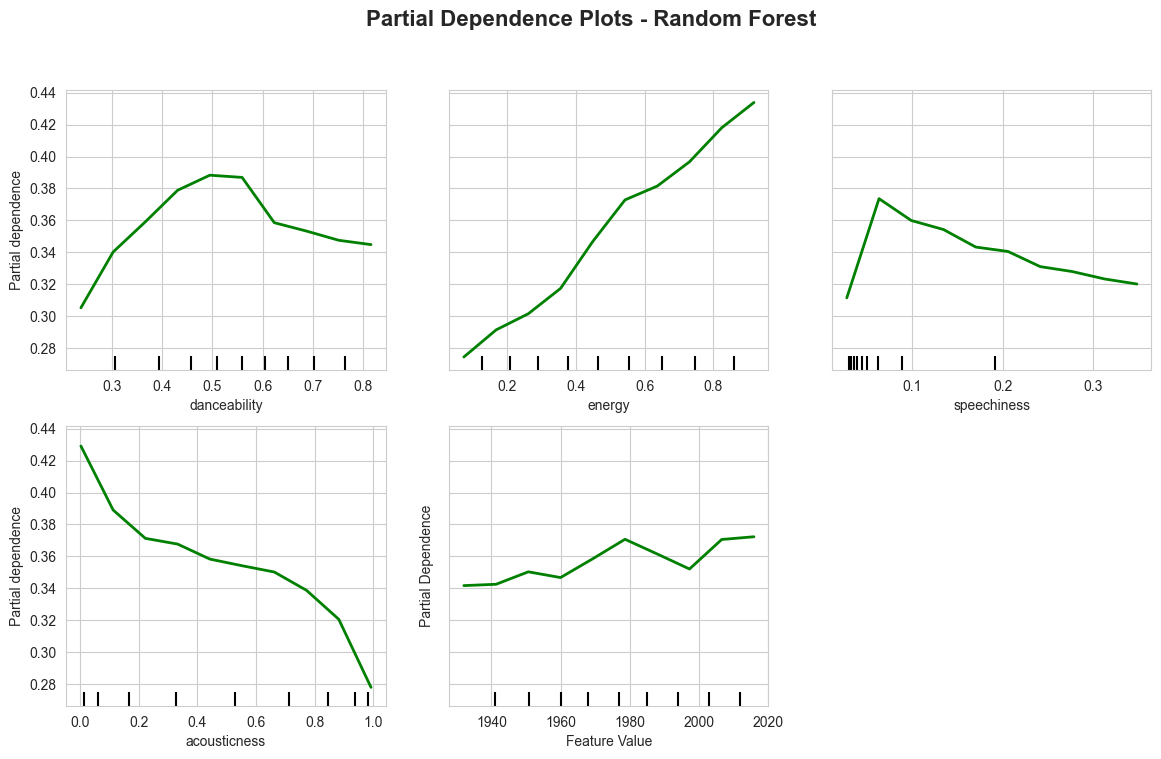

In [59]:
#PDP [2]
from sklearn.inspection import PartialDependenceDisplay
sns.set_style("whitegrid")

features = ['danceability', 'energy', 'speechiness', 'acousticness', 'year']

fig, ax = plt.subplots(figsize=(14, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf,                        
    X_train,
    features,
    grid_resolution=10,             
    subsample=50,                   
    n_jobs=-1,                      
    target=2,
    ax=ax,
    line_kw={"color": "blue", "linewidth": 2},
    pd_line_kw={"color": "green", "linewidth": 2}
)

plt.suptitle('Partial Dependence Plots - Random Forest', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.88)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.show()

Nous pouvons dés lors passer à l'étude des PDP pour la dernière modalité, c'est à dire le tempo rapide. Nous observons que la danceabilité augmente cette probabilité jusqu’à un niveau modéré (~0.5), puis diminue légèrement. La variable energy a un effet clairement croissant : plus un morceau est énergique, plus il est susceptible d’avoir un tempo rapide. À l’inverse, l’acousticness a une influence négative nette : les morceaux très acoustiques sont moins rapides.

La speechiness montre une relation non linéaire : une faible présence de parole favorise un tempo rapide, mais un excès le réduit. Enfin, l’année de sortie présente une légère tendance croissante, suggérant que les morceaux récents ont plus souvent un tempo élevé. De ce faite globalement, ces courbes confirment des tendances cohérentes avec l’intuition musicale tout en révélant quelques effets subtils.



## Interprétation par individus

### LIME

In [36]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="classification"
)
i = 22
sample = X_test.iloc[i].values

explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=lambda x: best_rf.predict_proba(pd.DataFrame(x, columns=X_train.columns))
)

explanation.show_in_notebook(show_table=True)

Enfin, avant de conclure, nous avons choisi de compléter notre interprétation globale par une analyse locale sur un individu spécifique, à l’aide de LIME. Il est important de noter que, pour des raisons de faisabilité et de ressources, nous n’avons fais le choix de ne pas utilisé SHAP, qui s’est révélé trop coûteux en temps de calcul.

LIME met en évidence que la prédiction en faveur d’un tempo lent (classe 0, probabilité 41 %) est principalement motivée par un ensemble de caractéristiques indiquant un morceau calme et peu dynamique : acousticness très élevé (0.97), année ancienne (1952), énergie faible (0.32), volume sonore bas (loudness = -7.13), et présence vocale importante (speechiness = 0.39). Ces facteurs ont pesé davantage que la danceabilité élevée (0.75), qui allait pourtant en faveur d’un tempo rapide. Ainsi, même si certains signaux peuvent indiquer du rythme, le profil général du morceau reste incompatible avec un tempo élevé selon le modèle.

Cette interprétation locale renforce les enseignements des Partial Dependence Plots (PDP), où l’on avait observé que des variables comme energy et acousticness ont un effet marqué et cohérent sur la probabilité d’un tempo rapide. Les PDP montraient notamment que plus un morceau est énergique, moins il est acoustique, et plus il est récent, plus il a de chances d’être rapide — ce que LIME illustre ici parfaitement sur un cas concret.

### Conclusion

En conclusion, notre étude met en lumière l’importance de certaines caractéristiques musicales dans la prédiction du tempo d’un morceau, notamment la danceability, l’energy, la speechiness, l’acousticness, la valence et l’année de sortie. L’analyse par permutation montre que la danceability est la variable la plus déterminante, bien que son influence reste modérée, ce qui laisse penser que d’autres variables pourraient améliorer le modèle si elles étaient prises en compte.

Les Partial Dependence Plots (PDP) permettent de mieux cerner l’effet marginal de ces variables selon les classes de tempo. Les morceaux lents sont généralement plus acoustiques, peu dynamiques, anciens et riches en éléments vocaux. À l’opposé, les morceaux rapides se caractérisent par une forte énergie, une faible acousticness et une tendance à être plus récents. Les morceaux à tempo moyen sont influencés par des niveaux modérés de danceability et d’energy, mais sont moins associés à une forte speechiness.

Enfin, nous avons complété cette approche globale par une interprétation locale à l’aide de LIME sur un individu particulier. Cette analyse a confirmé que, malgré une danceability élevée, des caractéristiques comme une faible énergie, une forte acousticness et une année ancienne orientaient la prédiction vers un tempo lent, illustrant ainsi la cohérence du modèle à l’échelle individuelle.

Toutefois, une limite importante réside dans la relative faiblesse des scores d’importance observés, ce qui suggère une marge d’amélioration possible. L’ajout de nouvelles variables plus expressives ou une exploration de modèles alternatifs pourrait renforcer la précision et la robustesse des prédictions futures.